# 라이브러리 임포트

In [ ]:
! pip install timm
# !pip install opencv-python # 로컬에서 할 경우 (import cv2) 라이브러리를 사용하기 위해서는 설치를 해줘야 함.

In [ ]:
import pandas as pd  # 데이터 조작 및 분석을 위한 라이브러리, 데이터프레임을 다루는데 사용
from sklearn.model_selection import train_test_split # 사이킷런 하위 모듈로 데이터셋을 학습 및 테스트 세트로 분할하는데 사용
import torch # PyTorch 딥러닝 프레임워크의 핵심 라이브러리로, 텐서 조작 및 신경망 모델 작성을 지원
import torch.nn as nn # PyTorch의 신경망 모듈 및 함수가 포함된 라이브러리, 딥러닝 모델 구축하는데 사용
import torch.nn.functional as F # PyTorch에서 제공하는 신경망 관련 함수 모음, 활성화 함수 및 손실 함수를 포함
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler # PtTorch의 데이터 로딩 및 변환을 위한 라이브러리, 데이터셋, 데이터 로더를 관리
import cv2 # OpenCV 라이브러리로, 이미지 처리 및 컴퓨터 비전 작업에 사용
import matplotlib.pyplot as plt # 데이터 시각화를 위한 라이브러리, 그래프 및 이미지 플로팅에 사용
import numpy as np # 수치 계산을 위한 라이브러리, 다차원 배열 및 수학 함수를 지원
import torchvision.transforms as T # PyTorch의 이미지 변환 및 전처리를 위한 모듈, 데이터 augmentation 및 이미지 변환을 수행
import timm # PyTorch 이미지 모델 라이브러리로, 다양한 이미지 분류 모델을 제공
from sklearn.metrics import accuracy_score, f1_score # 사이킷런 라이브러리 하위 모듈로, 모델 평가 및 측정에 사용되는 메트릭을 제공
from glob import glob # 지정된 패턴과 일치하는 파일또는 디렉터리 이름 목록을 반환, 파일의 내용 자체는 읽지 않는다.
import os # os운영체제와 상호작용하기 위한 라이브러리, 파일 및 디렉토리 관리에 사용
from tqdm import tqdm # 반복작업의 진행 상황을 시각화해주는 라이브러리로, 주로 반복문에 사용

# Configuration 설정

In [ ]:
# 코랩 환경에서 구글 드라이브에서 데이터를 불러와야할때
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# zip파일 형태 불러올때 사용
# model_dir = './data' # "data"라는 디렉터리가 생성될 경로를 지정, 압축 형태에 데이터셋을 저장하기 위한 공간.
# os.makedirs(model_dir, exist_ok=True) # 지정된 경로에 디렉터리 생성하고, exist_ok=True 인수는 디렉토리가 이미 존재하는 경우 오류가 발생하지 않도록 한다.

# 셸 명령어로 경로에 있는 압축 파일을 풀고 -d 옵션으로 추출된 파일이 저장 될 디렉토리를 지정해준다.
# !unzip "/content/drive/MyDrive/Colab Notebooks/이어드림 2차 모의 경진대회/train.zip" -d /content/data
# !unzip "/content/drive/MyDrive/Colab Notebooks/이어드림 2차 모의 경진대회/test.zip" -d /content/data

In [ ]:
# 데이터셋을 불러 올 경로 설정
data_dir = '/content/drive/MyDrive/Colab Notebooks/이어드림 2차 모의 경진대회' #'/content/data'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'

In [ ]:
class dotdict(dict): # Python 내장 클래에스 상속을 받아 dotdict 라는 클래스 정의
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get # dictionary에서 지정된 key와 연관된 값을 검색하는데 사용
    __setattr__ = dict.__setitem__ # dictionary key에 대한 값을 설정할 수 있다.
    __delattr__ = dict.__delitem__ # dictionary key에 대한 값을 삭제할 수 있다.



cfg = dotdict(
    device='cuda', # device key의 값을 'cuda' 로 설정 , cpu
    batch_size=8, # batch_size의 키 값을 8로 설정
    epochs=10, # epochs key 값을 20으로 설정
    lr=1e-4,) # lr(학습률) 키의 값을 1e-r(0.0001)로 설정, 1e-4

# Simple EDA

In [ ]:
 # glob 함수를 사용하여 train_dir 디렉터리 내의 defect_images 디렉터리에에서 확장자가 .png인 모든 파일을 검색
train_defect_images = glob(train_dir + '/defect_images/*.png') # 결함 제품 이미지(30장)

# train_defect_mask_images = glob(train_dir + '/defect_masks/*.png') # 결함 부분 세그멘테이션 마스크 (30장)

# glob 함수를 사용하여 train_dir 디렉터리 내의 normal_images 디렉터리에에서 확장자가 .png인 모든 파일을 검색
train_normal_images = glob(train_dir + '/normal_images/*.png') # 정상 제품 이미지 (6790장)


# print(len(train_defect_mask_images))
print(f'total number of train dataset : {len(train_defect_images) + len(train_normal_images)}, defect : {len(train_defect_images)}, normal : {len(train_normal_images)}')

total number of train dataset : 6820, defect : 30, normal : 6790


Text(0.5, 1.0, 'dist. of train dataset')

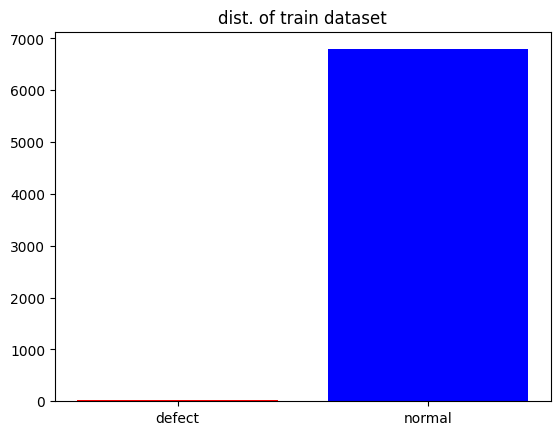

In [ ]:
# 클래스 분포 체크

# matplotlib를 사용하여 막대형 차트를 생성, ['defect', 'normal'] x축의 막대에 대한 레이블 목록 '결함', '정상' 카테고리 지정
# [len(train_defect_images), len(train_normal_images)] 막대의 높이를 나타내는 값 목록, 결함 이미지, 정상 이미지의 개수를 나타냄
# , color=['red', 'blue'] 결함은 빨간색, 정상은 파란색
plt.bar(['defect', 'normal'], [len(train_defect_images), len(train_normal_images)], color=['red', 'blue'])
plt.title('dist. of train dataset')

# 데이터 분할

In [ ]:
total_dataset = train_defect_images + train_normal_images # train_defect_images + train_normal_images 두 파일의 목록을 함침 (total_dataset)


# label 목록 생성, train_defect_images(결함 이미지)에는 '1' 라벨을 할당
#  train_normal_images(정상 이미지) '2' 라벨을 할당, 각 목록의 길이에 따라 해당 레이블의 수가 결정됩니다.
label = [1] * len(train_defect_images) + [0] * len(train_normal_images)


# Stratified split
# scikit-learn 라이브러리의 train_test_split 라이브러리를 사용 데이터 세트와 레이블을 훈련 및 검증 세트로 분할
# total_dataset : (이미지 파일 이름이 포함된 데이터 세트), label 각 이미지에 해당하는 라벨 목록
# test_size=0.3 : 데이터의 30%를 검증에 사용하고 나머지 70%는 훈련에 사용
# random_state : 재현성을 위한 무작위 시드 설정, 값을 지정하면 동일한 결과를 얻을 수 있다.
# statify=label : 샘플링된 학습 세트와 검증세트 모두의 클래스 분포가 원래 데이터 세트와 유사하도록 보장,
# 즉, 학습 세트와 검증세트에서 모두에서 결함 이미지와 정상 이미지의 비율을 유지하는데 사용
X_train, X_val, y_train, y_val = train_test_split(total_dataset, label, test_size=0.4, random_state=42, stratify=label)

print(f'train dataset : {len(X_train)}, val dataset : {len(X_val)}') # 훈련 및 검증 데이터세트의 샘플 수를 인쇄
print(f'train label : {len(y_train)}, val label : {len(y_val)}') # 훈련 및 검증 세트의 레이블 수를 인쇄

train dataset : 4092, val dataset : 2728
train label : 4092, val label : 2728


In [ ]:
# total_dataset[:5]

In [ ]:
# X_train[:2]

# Pytorch CustomDataset 클래스 정의

In [ ]:
class CustomDataset(Dataset): # PyTorch에서 'Dataset' 클래스를 상속하여 사용자 정의 데이터셋을 생성

    # 생성자 메서드, 데이터셋 초기화 image_paths 이미지 파일 경로의 리스트를 받아오고 각 이미지 파일 경로를 저장
    # labels : 이미지에 대한 레이블 정보를 받아온다. 이 레이블은 이미지와 일대일 대응
    # transform : 이미지에 적용할 전처리(transform) 함수를 받아옴. 기본값  None으로 초기화, 필요시 데이터 전처리를 수행하는 함수 지정 가능
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self): # 데이터셋의 전체 길이를 반환하는 메서드
        return len(self.image_paths) # 데이터셋에 포함된 이미지의 총 수를 반환

    def __getitem__(self, idx): # 이 메서드는 데이터셋에서 특정 인덱스 idx에 해당하는 이미지와 레이블을 반환
        image_path = self.image_paths[idx] # 지정된 인덱스 idx에 해당하는 이미지 파일의 경로를 가져온다.

        # cv2.imread 는 지정된 경로에서 이미지 파일을 읽는데 사용되는 OpenCV 라이브러리의 함수.
        # image_path : 로드해야 하는 이미지의 파일 경로가 포함
        # cv2.IMREAD_GRAYSCALE : 이미지를 로드하는 방법을 지정하는 플래그. 여기서는 단일 채널 이미지(흑백)로 변환 된다는 의미
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # 이미지를 로드한 후 픽셀 값에 대해 정규화를 수행, 이미지의 각 픽셀 값을 255.0으로 나눈다. (읽어온 이미지는 0 ~ 1 사이의 값으로 정규화)
        # 0, 255 범위에서 [0, 1] 범위까지 픽셀 값의 크기를 조정, 딥러닝에서 이미지 데이터로 작업할 때 일반적인 전처리 단계, (훈련 프로세스 및 신경망 수렴을 개선)
        image = image / 255.0

        if self.transform: # 전처리 함수가 지정되어 있으면 해당 함수를 적용
            image = self.transform(image)

        label = self.labels[idx] # 지정된 인덱스 idx에 해당하는 이미지의 레이블을 가져온다.
        return image, label # 이미지와 레이블을 반환

In [ ]:
# 제공된 코드는 머신 러닝 모델을 학습하고 테스트하기 위한 데이터 로더를 설정하는 것으로 보입니다. 각 부분을 자세히 살펴보겠습니다:

train_dataset = CustomDataset(X_train, y_train) # CustomDataset을 사용하여 훈련 데이터 생성, X_train은 훈련 이미지 경로를 나타내고, y_train은 해당 레이블을 나타낸다. 모델을 훈련하는데 사용
test_dataset = CustomDataset(X_val, y_val) # 동일하게 테스트 데이터도 생성하고, X_val에는 유효성 검사 이미지의 경로가 포함되고, y_val에는 해당 레이블을 나타낸다., 모델의 성능을 평가하는데 사용


# 학습 데이터 세트에 대한 데이터 로더를설정. 데이터로더는 학습 중에 데이터를 일괄적으로 효율적으로 로드하는 역할을 한다.
# train_dataset : 이전에 생성한 훈련 데이터 셋
# batch_size = cfg.batch_size : 각 훈련 반복중에 함께 처리되는 샘플 수를 결정하는 배치 크기를 지정
# shuffle=True : True일 경우 데이터 로더가 각 에포크 동안 훈련 샘플을 무작위 순서로 제시한다는 것을 의미, 이렇게 하면 모델이 데이터의 순서를 학습하는 것을 방지할 수 있다.
# num_workers=2 : 데이터로딩에 사용할 작업 프로세스 수를 지정, 더 높게 지정하면 대규모 집합이 있는 경우 데이터로드 속도를 높일 수 있다.
# pin_memory=True : True로 설정하면 데이터 로더가 고정 메모리를 사용하도록 설정하여 트레이닝에 GPU를 사용하는 경우, CPU와 GPU 간의 데이터 전송 속도를 높일 수 있다.
train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=2, pin_memory=True)

# 테스트 데이터 세트에 대한 로더를 설정, 전체적으로는 train 데이터 로더와 동일하지만 일반적으로 일관된 평과 결과를 원하기 때문에 유효성 검사 또는,
# 테스트 데이터를 섞지 않으려는 경우 shuffle=False로 설정
test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
train_loader

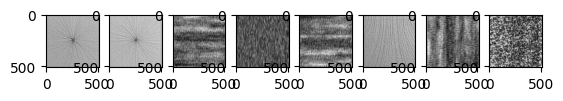

In [ ]:

for batch in train_loader: # # train_loader의 데이터 배치를 반복, 각 반복에서 트레이닝 이미지와 레이블 배치를 얻게 된다.
    # print(batch)
    imgs, labels = batch # 배치를 이미지와 레이블 두개의 변수로 언팩킹, imgs 에는 이미지 배치가 포함 되어 있고 labels 에는 해당 이미지에 레이블이 포함 되어있다.
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False) # 이미지를 표시하기 위한 그림과 그리드를 설정, 열은 배치의 이미지 수와 동일하게 subplot을 설정. squeeze=False 서브플롯이 겹치지 않도록 설정

    for i, img in enumerate(imgs): # 인덱스와 함께 배치의 이미지를 반복하는 루프를 시작

        # subplot 그리드에 특정 서브플롯(현재 작업할 서브플롯 위치)에 엑세스하고 imshow()를 이용해 서브플롯에 이미지 표시
        # img.squeeze() 이미지를 가져와 모양에서 1차원 항목을 제거, 이렇게 하면 이미지를 표시하기에 적합한 형식이 된다., 불필요한 채널을 제거하는 역할?
        # cmap='gray' : 이미지를 표시하기 위한 컬러맵이 회색조, 색상이 아닌 회색 음영으로 나타나도록 지정.
        axs[0, i].imshow(img.squeeze(), cmap='gray')

    break # 첫 번째 이미지 배치를 처리한 후 반복문 종료

# CNN Model 정의 (resnet18d)

In [ ]:
# 1에 가까우면 디펙트 0에 가까우면 normal?

class Net(nn.Module):
    def __init__(self): # 생성자
        super(Net, self).__init__() # PyTorch 모델을 정의할 때 필수적인 부모 클래스를 초기화

        # 레이어
        # self.encoder는 사전 훈련된 ResNet-18 모델인 네트워크의 백본, 흑백 이미지를 입력으로 사용
        # timm(PyTorch image Models) 라이브러리의 사전 훈련된 모델(ResNet-18) 아키텍처를 사용, in_chans = 1 은 흑백, 컬러면 3
        self.encoder =  timm.create_model('resnet18d', pretrained=True, in_chans=1) # resnet 다신에 다른거 넣어도 됨. 검색어 (timm 모델리스트 검색),
        # self.encoder =  timm.create_model('resnet34d', pretrained=True, in_chans=1)

        # 네트워크의 출력 레이어로, 1000개의 입력기능(ResNet-18 모델의 출력 기능과 일치)과 1개의 출력 기능이 있는 선형(완전 연결) 레이어로 구성
        # 단일 출력 특징은 이 네트워크가 이진 분류 작업에 사용됨을 나타낸다. (출력은 0과 1사이의 확률 점수를 나타냄)
        self.head = nn.Linear(1000, 1)


    # 네트워크를 통해 데이터가 흐르는 방식을 정의
    def forward(self, image, mode='train'):
        x = self.encoder(image) # 흑백 이미지를 입력으로 사용하고 입력된 이미지는 ResNet-18 아키텍쳐를 사용하여 특징을 추출하는 self.encoder를 통해 전달
        output = self.head(x) # 그 후 인코더의 출력 self.head 레이어를 통과
        output = torch.sigmoid(output) # 그 후 시그모이드 활성화 함수(torch.sigmoid)를 통과, 해당 함수는 출격을 0과 1사이로 조정해서 이진 분류에 적합하게 만듬
        return output

# 모델, Loss, Optimizer 선언

In [ ]:
model = Net() # 위에서 선언한 신경망 모델을 불러옴

model = model.to(cfg.device) # 모델을 to 메서드를 이용하여 cfg에 지정된 장치로 보냄 (여기서는 gpu로 이동)

# 모델의 손실 함수를 정의 , Binary Cross-Entropy Loss를 의미하여 일반적으로 이진 분류 문제에 사용
# 손실 함수는 예측된 값(0 ~ 1) 사이와 실제 이진 레이블 (0 or 1) 간의 차이를 측정
criterion = nn.BCELoss()

# 경사 기반 최적화에 널리 사용되는 Adam을 사용 여기에는 두가지 주요 인수가 필요한데
# model.parameters() : 학습 중에 업데이트해야 하는 모델의 매개변수(가중치 및 편향)을 지정
# lr = cfg.lr은 단계 크기를 제어하는 학습률을 지정
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)

# 학습 모델 저장 경로 설정

In [ ]:
# 학습 후 결과를 저장할 디렉터리 생성
model_dir = './models'
os.makedirs(model_dir, exist_ok=True)

# 학습 및 검증

In [ ]:
# Train and Valid Loop

metric_best = 0. # 모델의 성능 지표를 추적하고 괴상의 성능을 가진 모델을 저장하는데 사용
model_file = os.path.join(model_dir, f'best.pt') # 모델의 가장 좋은 성능을 나타내는 파일을 저장할 경로를 설정 'model_dir'은 디렉토리 이름, best.pt는 모델 파일의 이름

for epoch in range(cfg.epochs): # 현재 epoch 수 ('cfg.epochs')만큼 반복, 에폭은 전체 데이터셋을 한번 학습하는것을 의미

    # Train Loop
    train_loss = 0 # 현재 epoch애서 train_loss를 누적하여 추적
    train_outputs = [] # 훈련 데이터에 대한 모델 예측과
    train_labels = [] # 실제 레이블을 저장하기 위해 빈 리스트를 초기화


    for batch in tqdm(train_loader, desc=f'train-{epoch}'): # 훈련 데이터셋을 배치 단위로 반복, train_loader 는 데이터를 미니배치로 나누어 제공하는 데이터 로더.
        imgs, labels = batch # 배치에서 이미지와 레이블을 가져온다.

        imgs = imgs.to(cfg.device).float() # 이미지 배치 데이터를 지정된 장치(GPU or CPU)로 이동하고 float으로 변환
        labels = labels.to(cfg.device) # 레이블도 GPU 또는 CPU 에 배치

        optimizer.zero_grad() # 옵티마이저 그래디언트 초기화

        output = model(imgs.unsqueeze(1)) #모델에 이미지를 전달하고 예측 결과를 얻는다. unsqueeze는 이미지에 채널 차원을 추가하는 작업, 주로 흑백 이미지를 처리할 때 사용.
        loss = criterion(output, labels.unsqueeze(1).float()) # 손실 함수를 사용하여 예측과 실제 레이블 간의 손실을 계산

        loss.backward() # 역전파를 수행하여 그래디언트를 계산
        optimizer.step() # 옵티마이저를 사용하여 모델 파라미터를 업데이트

        train_loss += loss.item() # 현재 배치의 손실을 훈련 손실에 더한다.

        # 훈련 과정 중에 모델에 의해 생성된 예측값을 포함하는 텐서(output)를 GPU에서 CPU로 이동 (주로 추가처리나, NumPy 배열로 변환할 때 사용)
        # detach() : 텐서를 분리(detach)하는 것은 계산 그래프에서 해당 텐서를 제거하는 것을 의미, 주로 gradient를 계산하지 않고 값만 필요할때 유용 (평가나 시각화 작업을 수행할 때 사용,)
        # 그 후 분리된 텐서를 train_outputs 리스트에 추가. train_outputs는 각 배치에 대한 모델 예측값을 저장하는 데 사용
        train_outputs.append(output.cpu().detach()) # 현재 배치의 예측과 레이블을 각각 리스트에 추가
        train_labels.append(labels.cpu().detach()) # 위 작업과 동일하고 현재 배치의 실제 레이블을 train_labels 리스트에 추가.

    train_loss /= len(train_loader) # 현재 에폭에서의 훈련 손실을 전체 미니배치 수로 나누어 평균 손실을 계산



    # Validation Loop
    # 아래 코드는 모델 훈련 중에 검증 데이터에 대한 성능을 지속적으로 모니터링하고, 향상될 때마다 모델을 저장하여 최상의 모델을 보존한다.
    val_loss = 0 # 검증 데이터에 대한 손실(loss)을 초기화
    val_outputs = [] # 검증 데이터의 모델 출력 값을 저장할 빈 리스트 생성
    val_labels = [] # 검증 데이터의 실제 레이블을 저장할 빈 리스트를 생성

    # 검증(validation) 단계에서 그래디언트(gradient)를 계산하지 않도록 설정, 즉 모델 파라미터가 업데이트 되지 않는다.
    with torch.no_grad(): # validation 할때는 이거 무조건 필수
        for batch in tqdm(test_loader, desc=f'val-{epoch}'): # 검증 데이터를 미니배치(mini-batch)로 나누고 반복 'test_loader' 는 검증 데이터를 로드하는 데이터 로더

            imgs, labels = batch # 현재 미니배치에서 이미지와 레이블을 추출

            imgs = imgs.to(cfg.device).float() # 이미지 데이터를 모델이 사용하는 장치 (GPU 또는 CPU )로 이동하고 float 형태로 변환
            labels = labels.to(cfg.device) # 레이블 데이터를 모델이 사용하는 장치로 이동

            output = model(imgs.unsqueeze(1)) #모델에 이미지를 전달하여 출력값을 계산 unsqueeze(1) 를 통해 이미지에 채널 차원을 추가.
            loss = criterion(output, labels.unsqueeze(1).float()) # 모델의 출력과 실제 레이블 간의 손실을 계산.

            val_loss += loss.item() # 현재 미니배치의 손실을 총 검증 손실에 더한다.
            val_outputs.append(output.cpu().detach()) # 모델 출력 값을 CPU로 이동하고, 그래디언트를 분리(detach)하여 val_outputs 리스트에 추가.
            val_labels.append(labels.cpu().detach()) # 레이블을 cpu로 이동하고 그래디언트를 분리하여 val_labels 리스트에 추가.

    val_loss /= len(test_loader) # 검증  손실을 미니배치수로 나누어 평균 검증 손실을 계산
    train_outputs = (torch.cat(train_outputs) > 0.5).float().squeeze(-1) # 모델의 출력 값(train_outputs)을 이용하여 임계값 0.5 이상인지 여부를 판단하고 결과를 1 또는 0으로 변환
    val_outputs = (torch.cat(val_outputs) > 0.5).float().squeeze(-1) # 검증 출력 값(val_outputs)을 1또는 0으로 변환
    train_labels = torch.cat(train_labels) # 훈련 레이블(train_labels)을 하나의 텐서로 합친다.
    val_labels = torch.cat(val_labels) # 검증 레이블 (val_labels)을 하나의 텐서로 합친다.

    train_acc = accuracy_score(train_labels, train_outputs) # 훈련 데이터의 정확도를 계산한다.
    val_acc = accuracy_score(val_labels, val_outputs) # 검증 데이터의 정확도를 계산

    train_f1 = f1_score(train_labels, train_outputs, average='macro') # 훈련 데이터의 F1 스코어를 계산
    val_f1 = f1_score(val_labels, val_outputs, average='macro') # 검증 데이터의 F1 스코어를 계산

    if val_f1 > metric_best: # 현재의 검증 데이터에 대한 F1 스코어가 이전 최고 스코어(metric_best)를 초과하면
        print(f'metric_best ({metric_best:.6f} --> {val_f1:.6f}). Saving model ...') # 현재 스코어와 이전 최고 스코어를 출력하고,

        # 모델의 상태를 파일로 저장, 모델을 불러와 재사용할 수 있도록 하기 위한것
        # model.state_dict()은 모델의 가중치(weight)와 다른 학습 가능한 매개변수들을 포함한 상태 정보를 나타낸다.
        # model_file 은 모델을 저장할 파일 경로
        torch.save(model.state_dict(), model_file)
        metric_best = val_f1 #  새로운 최고 스코어를 현재의 val_f1으로 업데이트 다음 epoch에서 현재 스코어를 기준으로 더 좋은 성능을 찾을 수 있다.




    # 현재 에폭, train_loss, val_loss, 정확도, F1 스코어 출력
    print(f'Epoch: {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, Train Acc: {train_acc}, Val Acc: {val_acc}, Train F1: {train_f1}, Val F1: {val_f1}')


val-0: 100%|██████████| 341/341 [00:23<00:00, 14.33it/s]


metric_best (0.000000 --> 0.498898). Saving model ...
Epoch: 0, Train Loss: 0.04140090550521336, Val Loss: 0.03690757159946986, Train Acc: 0.9946236559139785, Val Acc: 0.9956011730205279, Train F1: 0.49865229110512127, Val F1: 0.49889786921381335


val-1: 100%|██████████| 341/341 [00:23<00:00, 14.50it/s]


Epoch: 1, Train Loss: 0.03496518398196713, Val Loss: 0.040016076147223106, Train Acc: 0.9956011730205279, Val Acc: 0.9956011730205279, Train F1: 0.49889786921381335, Val F1: 0.49889786921381335


val-2: 100%|██████████| 341/341 [00:23<00:00, 14.24it/s]


Epoch: 2, Train Loss: 0.032749121329288755, Val Loss: 0.03413213503648065, Train Acc: 0.9956011730205279, Val Acc: 0.9956011730205279, Train F1: 0.49889786921381335, Val F1: 0.49889786921381335


val-3: 100%|██████████| 341/341 [00:23<00:00, 14.38it/s]


Epoch: 3, Train Loss: 0.029443848662253913, Val Loss: 0.036356572788946134, Train Acc: 0.9956011730205279, Val Acc: 0.9956011730205279, Train F1: 0.49889786921381335, Val F1: 0.49889786921381335


val-4: 100%|██████████| 341/341 [00:21<00:00, 15.55it/s]


Epoch: 4, Train Loss: 0.025200052582391663, Val Loss: 0.03773752776660091, Train Acc: 0.9956011730205279, Val Acc: 0.9956011730205279, Train F1: 0.49889786921381335, Val F1: 0.49889786921381335


val-5: 100%|██████████| 341/341 [00:23<00:00, 14.40it/s]


Epoch: 5, Train Loss: 0.026595354220660283, Val Loss: 0.035919038528469636, Train Acc: 0.9956011730205279, Val Acc: 0.9956011730205279, Train F1: 0.49889786921381335, Val F1: 0.49889786921381335


val-6: 100%|██████████| 341/341 [00:23<00:00, 14.57it/s]


Epoch: 6, Train Loss: 0.023709287568784987, Val Loss: 0.03911853533769381, Train Acc: 0.9956011730205279, Val Acc: 0.9956011730205279, Train F1: 0.49889786921381335, Val F1: 0.49889786921381335


val-7: 100%|██████████| 341/341 [00:22<00:00, 15.07it/s]


Epoch: 7, Train Loss: 0.017998265717551476, Val Loss: 0.04138350835318549, Train Acc: 0.9956011730205279, Val Acc: 0.9956011730205279, Train F1: 0.49889786921381335, Val F1: 0.49889786921381335


val-8: 100%|██████████| 341/341 [00:25<00:00, 13.33it/s]


Epoch: 8, Train Loss: 0.02467283481917093, Val Loss: 0.04012356564208668, Train Acc: 0.9958455522971652, Val Acc: 0.9956011730205279, Train F1: 0.5515905501659846, Val F1: 0.49889786921381335


val-9: 100%|██████████| 341/341 [00:22<00:00, 15.06it/s]

Epoch: 9, Train Loss: 0.01615140733207454, Val Loss: 0.050363256351009335, Train Acc: 0.9951124144672532, Val Acc: 0.9956011730205279, Train F1: 0.5821078431372549, Val F1: 0.49889786921381335


# Pytorch CustomTestDataset 클래스 정의

In [ ]:
# 아래 코드는 커스텀 데이터셋을 만들고, 해당 데이터셋에서 이미지를 가져오는 기능을함. 주로 PyTorch에서 모델을 학습하거나 테스트할 때 사용

class CustomTestDataset(Dataset): # CustomTestDataset 클래스를 정의하고 'Dataset' 클래스를 상속

    # 클래스의 생성자 메서드, 이 메서드는 초기화 작업을 수행, image_paths는 이미지 파일 경로의 리스트를 나타내며,
    # transform은 옵션으로 이미지에 적용할 변환(transform)을 나타낸다.
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths # 이미지의 파일 경로를 클래스 내의 속성으로 저장.
        self.transform = transform # 이미지 변환을 클래스 내의 속성으로 저장

    def __len__(self): # 데이터셋의 총 데이터 개수를 반환하는 메서드,
        return len(self.image_paths) # 이미지 파일 경로의 리스트의 길이를 반환

    def __getitem__(self, idx): # 주어진 인덱스 'idx'에 해당하는 데이터를 가져오는 메서드, 이 메서드는 데이터셋의 핵심 역할

        image_path = self.image_paths[idx] # 주어진 인덱스에 해당하는 이미지 파일 경로를 선택
        image_name = os.path.basename(image_path) # 이미지 파일 경로에서 파일 이름만 추출
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # OpenCV를 사용하여 이미지를 그레이스케일로 읽어온다.
        image = image / 255.0 # 이미지 픽셀 값을 0에서 1 사이의 값으로 정규화

        if self.transform: # 변환(transform)이 설정되어 있다면, 이미지에 해당 변환을 적용
            image = self.transform(image)

        return image, image_name # 이미지와 이미지 파일 이름을 반환

In [ ]:
# test_dir은 파일이 저장된 디렉토리 경로를 나타내며, /images/*.png는 해당 디렉토리 아래의 모든 확장자가 .png인 파일을 가져오라는 명령. 즉, PNG 확장자를 가진 이미지 파일들을 선택
# glob 함수는 파일 경로를 패턴에 따라 검색하고, 해당 패턴에 맞는 모든 파일의 경로를 리스트로 반환. 여기서는 PNG 확장자를 가진 이미지 파일들의 경로를 리스트로 저장
test_images = glob(test_dir + '/images/*.png')


# 앞서 가져온 PNG 이미지 파일들의 경로가 저장된 리스트의 길이를 나타냄, 즉 PNG 확장자를 가진 이미지 파일의 개수를 확인
print(f'the number of test images : {len(test_images)}')

the number of test images : 9100


In [ ]:
test_dataset = CustomTestDataset(test_images) # 이전에 생성한 PNG 확장자를 가진 이미지 파일들의 경로를 담고 있는 리스트를 이용해 테스트 데이터셋을 생성.

# test_loader는 데이터를 미니배치로 분할하고 로드할 수 있게 해주는 데이터 로더 이를 통해 모델을 사용하여 테스트 데이터에 대한 예측을 수행할 수 있다.
# test_dataset은 이전에 생성한 테스트 데이터셋을 나타낸다.
# batch_size는 미니배치의 크기를 나타내며 cfg.batch_size에 설정된 값으로 설정
# shuffle는 데이터를 무작위로 섞을지 여부확인  False로 설정되어 있으면 데이터를 섞지 않는다.
# num_workers 데이터를 로드할 때 사용할 CPU 코어의 수를 나타냄, 여기서는 2개의 코어를 사용
# pin_memory는 GPU에서 데이터 로드할 때 메모리 핀(pin)여부를 나타낸다. True로 설정되면 GPU 메모리에 데이터를 고정시켜 더 빠르게 로드할 수 있도록 도와줌.
test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=2, pin_memory=True)

# 학습된 모델 로드

In [ ]:
# 학습된 모델을 불러와서 해당 디바이스(GPU 또는 CPU)로 이동시켜 사용할 수 있도록 하는 모델링 로딩하는 부분


model_dir = './models' # 모델 파일을 저장할 디렉토리 경로를 지정. 여기서는 ./models 라는 현재 작업 디렉토리내의 models폴더를 가라킨다.
model_file = os.path.join(model_dir, f'best.pt') # model_dir에 지정한 디렉토리 경로와 파일 이름 best.pt를 합쳐서 모델 파일의 전체 경로를 생성.

model = Net() # 위에서 정의한 Net() 클래스의 인스턴스를 생성하여 모델을 초기화, 새로운 모델을 만드는 부분

# 모델의 학습된 가중치와 매개변수를 불러온다. torch.load(model_file)는 이전에 저장한 모델 파일 ("best.pt")을 로드하고, 그 모델의 상태 사전을 모델에 적용
# 즉, 학습된 모델의 가중치와 구조를 불러온다.
model.load_state_dict(torch.load(model_file))

# 모델을 GPU 또는 CPU로 이동 시킨다. cfg.device에 지정된 디바이스로 모델을 이동
# 이렇게 하면 모델이 지정된 디바이스에서 연산을 수행
model = model.to(cfg.device)

# 추론 수행

In [ ]:
image_names = [] # 테스트 이미지의 파일 이름을 저장하는데 사용되는 리스트
test_outputs = [] # 테스트 데이터에 대한 모델의 예측값을 저장하는데 사용.
with torch.no_grad(): # 그래디언트 계산을 비활성화, 테스트 단계에서는 그래디언트 계산이 필요 없음
    for i, batch in enumerate(tqdm(test_loader)): # test_loader에서 미니배치를 하나씩 가져와 반복문 실행, enumerate 함수를 사용하여 현재 미니배치의 인덱스를 i도 같이 전달.
        imgs, image_name = batch # 현재 미니배치에서 이미지 데이터(imgs) 와 이미지 파일 이름(image_name)을 추출.
        imgs = imgs.to(cfg.device).float() # 이미지 데이터를 모델이 사용하는 디바이스(cfg.device)로 이동하고 데이터 타입을 float으로 변환



        output = model(imgs.unsqueeze(1)) # 모델에 이미지 데이터를 입력으로 주고 예측값(output)을 얻는다. unsqueeze(1)은 이미지에 채널 차원을 추가하는 작업  모델에 입력하기 위한 전처리 과정
        test_outputs.append(output.cpu().detach()) # 예측값을 test_outputs 리스트에 추가 .cpu().detach()는 GPU에서 CPU로 데이터를 이동하고 그래디언트 계산을 비활성화하는 작업
        image_names.extend(image_name) # 현재 미니배치에서 추출한 이미지 파일 이름을 image_names 리스트에 추가

test_outputs = (torch.cat(test_outputs) > 0.5).int().squeeze(-1) # 테스트 결과를 이진 분류 결과로 변환. 예측값(test_outputs)을 0.5를 기준으로 임계치를 설정하여 이진 분류 결과를 얻고, squeeze(-1)은 마지막 차원을 압축하는 작업

100%|██████████| 1138/1138 [01:47<00:00, 10.57it/s]


# 추론 결과 저장

In [ ]:
# 'ImageId'와 'answer' 두 개의 열을 가지는 데이터프레임(submission)을 생성.
# 'ImageId' 열에는 이미지 파일 이름(image_names)이, 'answer' 열에는 모델의 테스트 결과(test_outputs)가 들어가고 test_outputs를 리스트로 변환하여 데이터프레임에 추가한다.
submission = pd.DataFrame({'ImageId': image_names, 'answer': test_outputs.tolist()})


# 생성된 데이터프레임을 'ImageId' 열을 기준으로 정렬하고 이미지 파일 이름을 기준으로 데이터프레임이 정렬
# 그리고 reset_index(drop=True)를 사용하여 정렬된 데이터프레임의 인덱스를 재설정하고 이전 인덱스를 삭제 (데이터프레임이 정렬된 상태로 최종적으로 저장)
submission = submission.sort_values(by=['ImageId']).reset_index(drop=True)

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
submission

In [ ]:
submission['answer'].value_counts()

0    9100
Name: answer, dtype: int64

0    9100
Name: answer, dtype: int64